# Corpora of Questions and Answers

Hypothesis: Female witnesses generally give shorter, curter responses than male witnesses.

Is this true?  More interestingly, why would this be?  Is it because they had different roles (defence vs prosecution and/or were called in different types of trials (number of witnesses, severity of crime etc))?  And/or is it because they were asked different types of questions e.g., more closed questions?

To answer these questions, I have built 2 pairs of parallel corpora - one for female witnesses and one for male witnesses.  For each gender, there is a pair of parallel corpora where one corpus is the question they were asked and the other corpus contains their answer.  There is also a parallel metadata file which links the corpora to their trial (and utterance id)

First, we need to establish whether there are any differences between the answers (and what they are).  Then link them to possible causes.   One approach would be to annotate questions (and answers) with their type.  A second approach would be to measure the similarity of questions (e.g., using n-gram overlap) and then find the nearest question in the other question corpus and look at the characteristics of the answer (e.g., length etc).  This would avoid having to do any categorization.  Could also look at near neighbours within the same gender, to study expected variation in answers.

Another potential analysis would be to derive features of the questions / answers (e.g., length, average number of characters, longest word, ratio of function words to content words, number of adjectives ... and/or bag of words or bag of vectors) and then see how the vectors cluster / do PCA and attempt to split the male/female classes.  Feature ablation would indicate what features are distinguishing

## Differences in Answers

First lets examine how answers differ between male and female witnesses

In [1]:
import spacy
import pandas as pd
import matplotlib as plt
%matplotlib inline
import time
from collections import defaultdict
import operator,math
from gensim.models import Word2Vec

In [16]:
import nlp_tools


In [35]:
p=100
female_answers=['answers_wv_f']
male_answers=['answers_wv_m']
nlp=spacy.load('en')
female_answer_corpus=nlp_tools.corpus(female_answers,nlp,prop=p,ner=False)

 

Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 1330
Completed 1330 docs (10.005265929436545% complete)
Completed 2660 docs (20.01053185887309% complete)
Completed 3990 docs (30.015797788309637% complete)
Completed 5320 docs (40.02106371774618% complete)
Completed 6650 docs (50.02632964718273% complete)
Completed 7980 docs (60.031595576619274% complete)
Completed 9310 docs (70.03686150605581% complete)
Completed 10640 docs (80.04212743549236% complete)
Completed 11970 docs (90.04739336492891% complete)
Number of documents is 13293


In [36]:
male_answer_corpus=nlp_tools.corpus(male_answers,nlp,prop=p,ner=False)


Loading sourcefiles
Running basic analysis
Analysing 100%. Chunks of size 5412
Completed 5412 docs (10.000554354454238% complete)
Completed 10824 docs (20.001108708908475% complete)
Completed 16236 docs (30.001663063362713% complete)
Completed 21648 docs (40.00221741781695% complete)
Completed 27060 docs (50.00277177227119% complete)
Completed 32472 docs (60.003326126725426% complete)
Completed 37884 docs (70.00388048117966% complete)
Completed 43296 docs (80.0044348356339% complete)
Completed 48708 docs (90.00498919008814% complete)
Number of documents is 54117


Mean is 1.3045211765590912 and sd is 1.1087452601267422


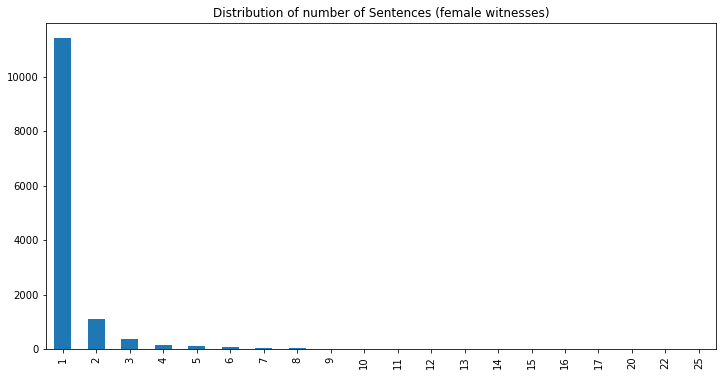

In [37]:
femaledocs=nlp_tools.visualise(female_answer_corpus.doclengths,heading=("Sentences (female witnesses)"),makesquash=False)

Mean is 1.316739656669808 and sd is 1.2596158261884738


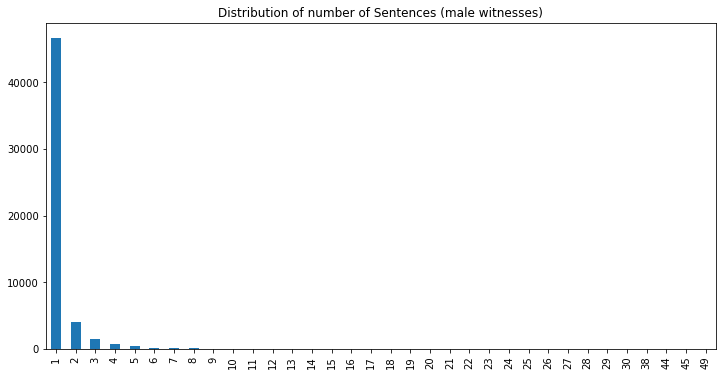

In [38]:
maledocs=nlp_tools.visualise(male_answer_corpus.doclengths,heading=("Sentences (male witnesses)"),makesquash=False)

Mean is 32.23493454818061 and sd is 61.15774157468008


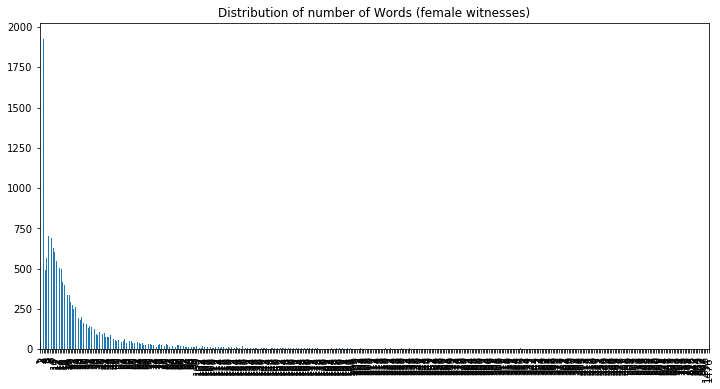

In [39]:
femalesents=nlp_tools.visualise(female_answer_corpus.sentencelengths,heading=("Words (female witnesses)"),makesquash=False)

Mean is 18.39337175792507 and sd is 21.735626921720936


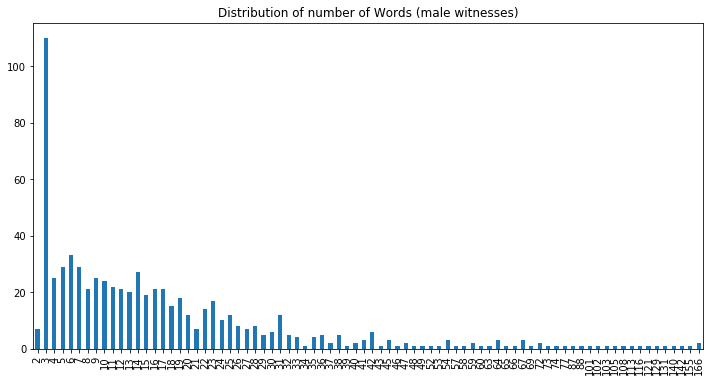

In [25]:
malesents=nlp_tools.visualise(male_answer_corpus.sentencelengths,heading=("Words (male witnesses)"),makesquash=False)

Mean is 3.2946978994107186 and sd is 2.050534504827923


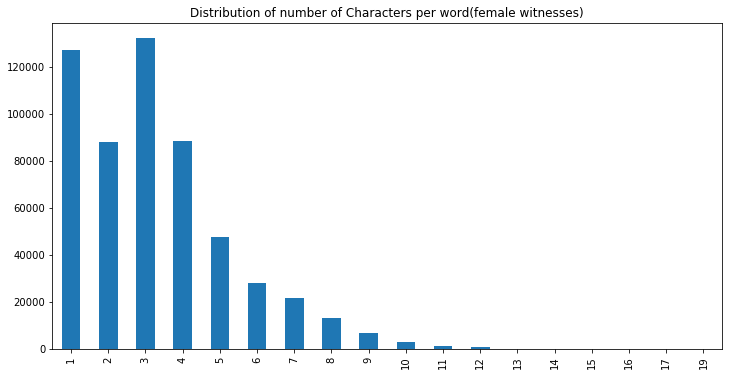

In [40]:
femaleswords=nlp_tools.visualise(female_answer_corpus.wordlengths,heading=("Characters per word(female witnesses)"),makesquash=False)

Mean is 3.365081674028607 and sd is 2.15039841872516


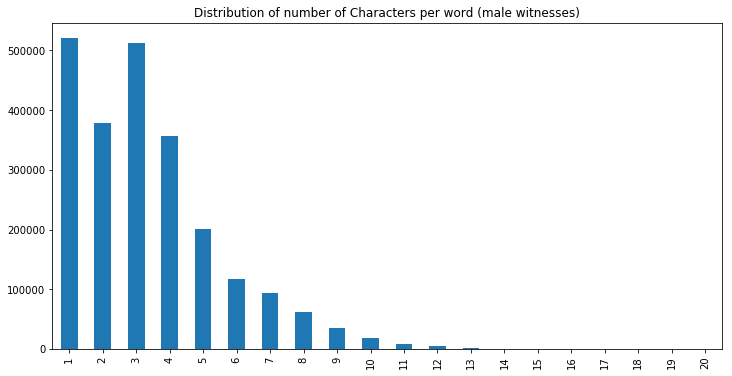

In [41]:
malesents=nlp_tools.visualise(male_answer_corpus.wordlengths,heading=("Characters per word (male witnesses)"),makesquash=False)

In [42]:
acorpusdict={'female':female_answer_corpus,'male':male_answer_corpus}

def do_averages(acorpusdict,gender='female'):
    acorpus=acorpusdict[gender]
    avsents,_=nlp_tools.summarise(acorpus.doclengths)
    avwords,_=nlp_tools.summarise(acorpus.sentencelengths)
    avchars,_=nlp_tools.summarise(acorpus.wordlengths)

    print("For {}s, average number of sentences per utterance = {:f}".format(gender,avsents))
    avwpu=avsents*avwords
    print("Average number of words per sentence = {:f}, average number of words per utterance = {:f}".format(avwords,avwpu))
    avcps=avchars*avwords
    avcpu=avcps*avsents
    print("Average number of characters per word = {:f}, average number of characters per sentence = {:f}, average number of characters per utterance = {:f}".format(avchars,avcps,avcpu))
    
do_averages(acorpusdict,gender='female')

Mean is 1.3045211765590912 and sd is 1.1087452601267422
Mean is 32.23493454818061 and sd is 61.15774157468008
Mean is 3.2946978994107186 and sd is 2.050534504827923
For females, average number of sentences per utterance = 1.304521
Average number of words per sentence = 32.234935, average number of words per utterance = 42.051155
Average number of characters per word = 3.294698, average number of characters per sentence = 106.204371, average number of characters per utterance = 138.545851


In [43]:
do_averages(acorpusdict,gender='male')

Mean is 1.316739656669808 and sd is 1.2596158261884738
Mean is 32.41534985545483 and sd is 57.96701499951284
Mean is 3.365081674028607 and sd is 2.15039841872516
For males, average number of sentences per utterance = 1.316740
Average number of words per sentence = 32.415350, average number of words per utterance = 42.682577
Average number of characters per word = 3.365082, average number of characters per sentence = 109.080300, average number of characters per utterance = 143.630356


So it would seem that there is very little difference in terms of lengths of utterances.  Males are making slightly longer utterances (in terms of numbers of sentences, words and characters).  They are also using longer words.  This was the other way round when only the first 1% of data was considered (suggestive of a time factor? women are talking less later in the time period?!)